In [1]:
1

1

In [2]:
from langchain_ollama.llms import OllamaLLM
from langchain_core.runnables import RunnableLambda

model = OllamaLLM(model="deepseek-r1")

def remove_think_tags(text):
    import re
    return re.sub(r"<think>.*?</think>", "", text, flags=re.DOTALL).strip()


chain = model | RunnableLambda(remove_think_tags)
chain.invoke("Hello deepseek!")

'Hello! How can I assist you today? 😊'

In [11]:
### Embedding model intialization
from gen_ai_hub.proxy.langchain.init_models import init_embedding_model

embedding_model = init_embedding_model(model_name = "text-embedding-ada-002")

embedding_model.embed_query("Hello world!!!")

[0.011166534386575222,
 0.002552350750193,
 -0.01770380511879921,
 -0.03453180193901062,
 -0.012192479334771633,
 -0.003684643656015396,
 -0.013600025326013565,
 0.0020534538198262453,
 -0.0031904384959489107,
 -0.01776636205613613,
 0.017753850668668747,
 0.011573159135878086,
 -0.0197807177901268,
 -0.0034375409595668316,
 0.0036064465530216694,
 0.012949426658451557,
 0.020018436014652252,
 -0.014400763437151909,
 -0.0011072697816416621,
 0.018091661855578423,
 -0.018704727292060852,
 -0.012836822308599949,
 -0.0063589815981686115,
 -0.003284274833276868,
 -0.01592716947197914,
 0.002186388708651066,
 0.021106939762830734,
 -0.018542077392339706,
 0.02822599560022354,
 -0.030227839946746826,
 0.008670485578477383,
 -0.003941129893064499,
 -0.004932668060064316,
 -0.024272354319691658,
 0.01403792854398489,
 0.0026070885360240936,
 0.006950151175260544,
 -0.021307123824954033,
 0.021407216787338257,
 -0.0081387460231781,
 0.013287237845361233,
 0.003387494944036007,
 0.01304951868951

In [10]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader("../data/Deepseek_V3.pdf")

docs = loader.load()
len(docs), docs[0]



(53,
 Document(metadata={'producer': 'pdfTeX-1.40.26', 'creator': 'LaTeX with hyperref', 'creationdate': '2024-12-26T09:17:33+00:00', 'author': '', 'keywords': '', 'moddate': '2024-12-26T09:17:33+00:00', 'ptex.fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.26 (TeX Live 2024) kpathsea version 6.4.0', 'subject': '', 'title': '', 'trapped': '/False', 'source': '../data/Deepseek_V3.pdf', 'total_pages': 53, 'page': 0, 'page_label': '1'}, page_content='DeepSeek-V3 Technical Report\nDeepSeek-AI\nresearch@deepseek.com\nAbstract\nWe present DeepSeek-V3, a strong Mixture-of-Experts (MoE) language model with 671B total\nparameters with 37B activated for each token. To achieve efficient inference and cost-effective\ntraining, DeepSeek-V3 adopts Multi-head Latent Attention (MLA) and DeepSeekMoE architec-\ntures, which were thoroughly validated in DeepSeek-V2. Furthermore, DeepSeek-V3 pioneers\nan auxiliary-loss-free strategy for load balancing and sets a multi-token prediction training\

In [19]:
from langchain_community.vectorstores import Chroma

vector_store = Chroma.from_documents(
    persist_directory= "../vectorstores/deepseek",
    embedding=embedding_model,
    documents=docs
    
)

In [23]:
# Create fetching tool from vecctor store
from langchain_core.tools import tool

@tool
def retrive(query:str):
    """Retrieve information related to a query."""
    retriver = vector_store.as_retriever(search_type = "similarity", search_kwargs = {"k" : 4})
    retrieved_docs = retriver.invoke(query)
    serealized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )

    return retrieved_docs, serealized


In [31]:
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.graph.message import BaseMessage, add_messages
from langchain_core.messages import SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated = [Sequence[BaseMessage], add_messages]
    chat_history:str


graph_builder = StateGraph(MessagesState)

In [ ]:
from langchain_core.messages import trim_messages
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder


trimmer = trim_messages(
    max_tokens=65,
    strategy="last",
    token_counter=model,
    include_system=True,
    allow_partial=False,
    start_on="human",
)


messages = [
    ("system", "You are a helpful Ai who answers best to your ability"),
    MessagesPlaceholder(variable_name="messages")
]

template = ChatPromptTemplate(
    messages=messages,
    input_variables = ["langauge"]
)


In [28]:
from gen_ai_hub.proxy.langchain.init_models import init_llm

llm = init_llm(model_name = "gpt-4o")

llm.invoke("Hello")

AIMessage(content='Hi there! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 8, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BQg7hoaoLmzJ5FqD8QD5kvvlRv0Bz', 'finish_reason': 'stop', 'logprobs': None}, id='run-cdb78463-246d-4c3e-8c19-b781ac690e48-0', usage_metadata={'input_tokens': 8, 'output_tokens': 11, 'total_tokens': 19, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [32]:
# Step 1: Generate an AIMessage that may include a tool-call to be sent.

def query_or_respond(state:MessagesState):
    llm_with_tools = llm.bind_tools([retrive])
    response = llm_with_tools.invoke(state["messages"])
    return {"messages" : response}



# Step 2: Execute the retrieval.
tools = ToolNode([retrive])   

In [39]:
# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. think user as a newbie and knows nothing about the topic"
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know."
        
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [40]:
# Build graph
graph_builder = StateGraph(MessagesState)

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

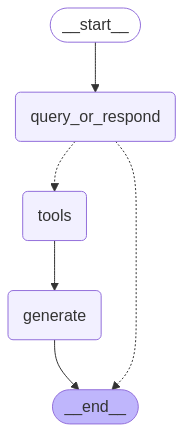

In [36]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [47]:
# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

while True:
    input_message = input("Enter your query: \n")
    if input_message == "end": break

    for step in graph.stream(
        {"messages": [{"role": "user", "content": input_message}]},
        stream_mode="values",
        config=config,
    ):
        step["messages"][-1].pretty_print()

================================ Human Message =================================

what is GRPO explain it to layman in depth
================================== Ai Message ==================================
Tool Calls:
  retrive (call_cMlojhp0csaDw6Dps7awplGj)
 Call ID: call_cMlojhp0csaDw6Dps7awplGj
  Args:
    query: GRPO meaning and explanation
================================= Tool Message =================================
Name: retrive

([Document(metadata={'page': 29, 'subject': '', 'author': '', 'title': '', 'trapped': '/False', 'creator': 'LaTeX with hyperref', 'page_label': '30', 'creationdate': '2024-12-26T09:17:33+00:00', 'total_pages': 53, 'ptex.fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.26 (TeX Live 2024) kpathsea version 6.4.0', 'source': '../data/Deepseek_V3.pdf', 'producer': 'pdfTeX-1.40.26', 'moddate': '2024-12-26T09:17:33+00:00', 'keywords': ''}, page_content='as inputs. The reward model is trained from the DeepSeek-V3 SFT checkpoints. To enhance its\nre

In [44]:
import streamlit as st

# Initialize chat history in session state
if "chat_history" not in st.session_state:
    st.session_state.chat_history = []

# Display existing chat messages
for message in st.session_state.chat_history:
    with st.chat_message(message["role"]):
        st.markdown(message["content"])

# Chat input box
if prompt := st.chat_input("Enter your query:"):
    # Append user message to chat history
    st.session_state.chat_history.append({"role": "user", "content": prompt})
    with st.chat_message("user"):
        st.markdown(prompt)

    # Placeholder for assistant's response
    with st.chat_message("assistant"):
        response_container = st.empty()

        # Stream the response from LangChain
        def generate_response():
            for step in graph.stream(
                {"messages": [{"role": "user", "content": prompt}]},
                stream_mode="values",
                config=config,
            ):
                content = step["messages"][-1].content
                yield content

        # Display the streaming response
        full_response = st.write_stream(generate_response())
        # Append assistant's response to chat history
        st.session_state.chat_history.append({"role": "assistant", "content": full_response})


2025-04-28 00:35:21.612 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-28 00:35:21.620 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-28 00:35:21.630 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-28 00:35:21.631 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-28 00:35:21.631 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-28 00:35:21.655 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-28 00:35:21.663 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
